# Read Data

In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('SUI_USDT_futures_15m_20241231.csv')

# Drop unused columns
df.drop(columns=['coin','unused', 'closetime'], inplace=True)

# Drop unused columns
df.drop(columns=['volume','quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote'], inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1683129600000,1.4030,1.4030,1.2652,1.3338
1,1683130500000,1.3339,1.3863,1.3327,1.3716
2,1683131400000,1.3717,1.3957,1.3547,1.3857
3,1683132300000,1.3866,1.3924,1.3652,1.3733
4,1683133200000,1.3731,1.3756,1.3405,1.3574
...,...,...,...,...,...
58323,1735620300000,4.0787,4.0850,4.0616,4.0828
58324,1735621200000,4.0829,4.0953,4.0738,4.0810
58325,1735622100000,4.0811,4.0990,4.0637,4.0982
58326,1735623000000,4.0982,4.1310,4.0900,4.1198


# Explore

In [2]:
df_setup = df.copy()

# Calculate candle body size
df_setup['body_size'] = abs(df_setup['closeprice'] - df_setup['openprice'])

# Calculate tail length
df_setup['high_tail'] = abs(df_setup['highprice'] - df_setup[['openprice', 'closeprice']].max(axis=1))
df_setup['low_tail'] = abs(df_setup['lowprice'] - df_setup[['openprice', 'closeprice']].min(axis=1))

# Calculate tail to body ratio
df_setup['high_tail_ratio'] = df_setup['high_tail'] / df_setup['body_size']
df_setup['low_tail_ratio'] = df_setup['low_tail'] / df_setup['body_size']

# Calculate body + tail
df_setup['body_high_tail_ratio'] = (df_setup['high_tail'] + df_setup['body_size']) / df_setup['openprice'] * 100
df_setup['body_low_tail_ratio'] = (df_setup['low_tail'] + df_setup['body_size']) / df_setup['openprice'] * 100

# Get next open price
df_setup['next_openprice'] = df_setup['openprice'].shift(-1)

df_setup

,opentime,openprice,highprice,lowprice,closeprice,body_size,high_tail,low_tail,high_tail_ratio,low_tail_ratio,body_high_tail_ratio,body_low_tail_ratio,next_openprice
0,1683129600000,1.4030,1.4030,1.2652,1.3338,0.0692,0.0000,0.0686,0.000000,0.991329,4.932288,9.821810,1.3339
1,1683130500000,1.3339,1.3863,1.3327,1.3716,0.0377,0.0147,0.0012,0.389920,0.031830,3.928330,2.916261,1.3717
2,1683131400000,1.3717,1.3957,1.3547,1.3857,0.0140,0.0100,0.0170,0.714286,1.214286,1.749654,2.259969,1.3866
3,1683132300000,1.3866,1.3924,1.3652,1.3733,0.0133,0.0058,0.0081,0.436090,0.609023,1.377470,1.543343,1.3731
4,1683133200000,1.3731,1.3756,1.3405,1.3574,0.0157,0.0025,0.0169,0.159236,1.076433,1.325468,2.374190,1.3570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58323,1735620300000,4.0787,4.0850,4.0616,4.0828,0.0041,0.0022,0.0171,0.536585,4.170732,0.154461,0.519773,4.0829
58324,1735621200000,4.0829,4.0953,4.0738,4.0810,0.0019,0.0124,0.0072,6.526316,3.789474,0.350241,0.222881,4.0811
58325,1735622100000,4.0811,4.0990,4.0637,4.0982,0.0171,0.0008,0.0174,0.046784,1.017544,0.438607,0.845360,4.0982
58326,1735623000000,4.0982,4.1310,4.0900,4.1198,0.0216,0.0112,0.0082,0.518519,0.379630,0.800351,0.727149,4.1199


In [4]:
import pandas as pd
import numpy as np

# Initialize parameters for iteration
# tr_ratios = np.arange(1, 6, 1).tolist()
# bt_ratios = np.arange(0.5, 0.9, 0.1).tolist()
tr_ratios = [2]
bt_ratios = [0.8]
maker_fee = 0.05  # Maker fee for the trades
results = []  # To store the results

# Outer loop for tr_ratio
for tr_ratio in tr_ratios:
    # Inner loop for bt_ratio
    for bt_ratio in bt_ratios:

        # Add a new column 'next_trend' and set default value to 0
        df_setup['next_trend'] = 0
        df_setup.loc[(df_setup['high_tail_ratio'] >= tr_ratio) & 
                     (df_setup['low_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_high_tail_ratio'] >= bt_ratio), 'next_trend'] = -1
        df_setup.loc[(df_setup['low_tail_ratio'] >= tr_ratio) & 
                     (df_setup['high_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_low_tail_ratio'] >= bt_ratio), 'next_trend'] = 1

        df_setup.dropna(inplace=True)

        # Initialize variables for trend alternation
        indices = []  # To store the captured indices and alternating trends
        previous_trend = None
        previous_index = None

        # Iterate through the DataFrame
        for idx, row in df_setup.iterrows():
            current_trend = row['next_trend']  # Current value of next_trend

            if previous_trend is None:
                if current_trend in [1, -1]:
                    previous_trend = current_trend
                    previous_index = idx
            else:
                if previous_trend == 1 and current_trend == -1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = -1
                    previous_index = idx
                elif previous_trend == -1 and current_trend == 1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = 1
                    previous_index = idx

        # Convert the captured indices into a DataFrame
        result_df = pd.DataFrame(indices, columns=['Start_Trend', 'Start_Index', 'End_Trend', 'End_Index'])

        # Filter df_setup based on Start_Index from result_df
        filtered_df_setup = df_setup.loc[result_df['Start_Index']]

        # Reset the index
        filtered_df_setup.reset_index(drop=True, inplace=True)

        # Backtest DataFrame
        df_backtest = filtered_df_setup.copy()
        df_backtest['pnl'] = (df_backtest['next_openprice'] - df_backtest['next_openprice'].shift(1)) / df_backtest['next_openprice'].shift(1) * 100
        df_backtest['pnl'] = np.where(df_backtest['next_trend'] == 1, df_backtest['pnl'] * -1, df_backtest['pnl'])

        # Calculate the sum of PnL
        total_pnl = df_backtest['pnl'].sum()

        # Count the rows in df_backtest
        row_count = len(df_backtest)

        # Calculate the total rows in df_setup for this combination
        total_rows_in_setup = len(df_setup)

        # Calculate win rate
        wins = df_backtest.apply(lambda row: 1 if ((row['pnl'] > 0 and row['next_trend'] == -1) or (row['pnl'] < 0 and row['next_trend'] == 1)) else 0, axis=1)
        win_rate = wins.sum() / row_count * 100 if row_count > 0 else 0

        # Calculate net PnL sum (subtracting fees)
        net_pnl_sum = total_pnl - row_count * maker_fee * 2

        # Calculate the ratio of df_backtest rows to df_setup rows
        backtest_to_setup_ratio = row_count / total_rows_in_setup * 100 if total_rows_in_setup > 0 else 0

         # Calculate score
        score = net_pnl_sum * backtest_to_setup_ratio

        # Append results to the list
        results.append({'tr_ratio': tr_ratio, 'bt_ratio': bt_ratio, 'pnl_sum': total_pnl, 'row_count': row_count, 
                        'win_rate': win_rate, 'net_pnl_sum': net_pnl_sum, 'backtest_to_setup_ratio': backtest_to_setup_ratio, 'score': score})


# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df


,tr_ratio,bt_ratio,pnl_sum,row_count,win_rate,net_pnl_sum,backtest_to_setup_ratio,score
0,2,0.8,342.53237,948,50.527426,247.73237,1.62557,402.706345


In [6]:
df_backtest[['']].tail(20)

,opentime,openprice,highprice,lowprice,closeprice,body_size,high_tail,low_tail,high_tail_ratio,low_tail_ratio,body_high_tail_ratio,body_low_tail_ratio,next_openprice,next_trend,pnl
928,1734102900000,4.8453,4.9272,4.8453,4.8676,0.0223,0.0596,0.0000,2.672646,0.000000,1.690298,0.460240,4.8676,-1,1.214339
929,1734298200000,4.6838,4.7010,4.6534,4.6917,0.0079,0.0093,0.0304,1.177215,3.848101,0.367223,0.817712,4.6916,1,3.615745
930,1734301800000,4.6940,4.7416,4.6937,4.7082,0.0142,0.0334,0.0003,2.352113,0.021127,1.014061,0.308905,4.7082,-1,0.353824
931,1734450300000,4.7413,4.7597,4.7127,4.7529,0.0116,0.0068,0.0286,0.586207,2.465517,0.388079,0.847869,4.7529,1,-0.949407
932,1734618600000,4.5289,4.5956,4.5070,4.5125,0.0164,0.0667,0.0055,4.067073,0.335366,1.834883,0.483561,4.5125,-1,-5.057965
933,1734630300000,4.2274,4.2715,4.1253,4.2452,0.0178,0.0263,0.1021,1.477528,5.735955,1.043194,2.836259,4.2454,1,5.919114
934,1734646500000,4.0571,4.0951,4.0532,4.0614,0.0043,0.0337,0.0039,7.837209,0.906977,0.936630,0.202115,4.0614,-1,-4.334103
935,1734714900000,4.5116,4.5256,4.3958,4.5176,0.0060,0.0080,0.1158,1.333333,19.300000,0.310311,2.699707,4.5176,1,-11.232580
936,1734733800000,4.5603,4.6161,4.5389,4.5455,0.0148,0.0558,0.0066,3.770270,0.445946,1.548144,0.469267,4.5457,-1,0.622012
937,1734796800000,4.6146,4.6372,4.5621,4.6297,0.0151,0.0075,0.0525,0.496689,3.476821,0.489750,1.464916,4.6298,1,-1.850100


In [7]:
import pandas as pd
import numpy as np

# Initialize parameters for iteration
tr_ratios = [2]
bt_ratios = [0.8]
maker_fee = 0.05  # Maker fee for the trades
results = []  # To store the results

# Outer loop for tr_ratio
for tr_ratio in tr_ratios:
    for bt_ratio in bt_ratios:
        # Add a new column 'next_trend' and set default value to 0
        df_setup['next_trend'] = 0
        df_setup.loc[(df_setup['high_tail_ratio'] >= tr_ratio) & 
                     (df_setup['low_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_high_tail_ratio'] >= bt_ratio), 'next_trend'] = -1
        df_setup.loc[(df_setup['low_tail_ratio'] >= tr_ratio) & 
                     (df_setup['high_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_low_tail_ratio'] >= bt_ratio), 'next_trend'] = 1

        df_setup.dropna(inplace=True)

        # Initialize variables for trend alternation
        indices = []
        previous_trend = None
        previous_index = None

        for idx, row in df_setup.iterrows():
            current_trend = row['next_trend']

            if previous_trend is None:
                if current_trend in [1, -1]:
                    previous_trend = current_trend
                    previous_index = idx
            else:
                if previous_trend == 1 and current_trend == -1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = -1
                    previous_index = idx
                elif previous_trend == -1 and current_trend == 1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = 1
                    previous_index = idx

        result_df = pd.DataFrame(indices, columns=['Start_Trend', 'Start_Index', 'End_Trend', 'End_Index'])

        filtered_df_setup = df_setup.loc[result_df['Start_Index']]
        filtered_df_setup.reset_index(drop=True, inplace=True)

        # Backtest DataFrame
        df_backtest = filtered_df_setup.copy()
        df_backtest['pnl'] = (df_backtest['next_openprice'] - df_backtest['next_openprice'].shift(1)) / df_backtest['next_openprice'].shift(1) * 100
        df_backtest['pnl'] = np.where(df_backtest['next_trend'] == 1, df_backtest['pnl'] * -1, df_backtest['pnl'])

        # Calculate cumulative PnL over time
        df_backtest['cumulative_pnl'] = df_backtest['pnl'].cumsum()

        # Calculate the sum of PnL
        total_pnl = df_backtest['pnl'].sum()

        # Count the rows in df_backtest
        row_count = len(df_backtest)

        total_rows_in_setup = len(df_setup)

        # Calculate win rate
        wins = df_backtest.apply(lambda row: 1 if ((row['pnl'] > 0 and row['next_trend'] == -1) or (row['pnl'] < 0 and row['next_trend'] == 1)) else 0, axis=1)
        win_rate = wins.sum() / row_count * 100 if row_count > 0 else 0

        net_pnl_sum = total_pnl - row_count * maker_fee * 2

        backtest_to_setup_ratio = row_count / total_rows_in_setup * 100 if total_rows_in_setup > 0 else 0

        score = net_pnl_sum * backtest_to_setup_ratio

        results.append({'tr_ratio': tr_ratio, 'bt_ratio': bt_ratio, 'pnl_sum': total_pnl, 'row_count': row_count, 
                        'win_rate': win_rate, 'net_pnl_sum': net_pnl_sum, 'backtest_to_setup_ratio': backtest_to_setup_ratio, 'score': score})

        # Display cumulative PnL for this backtest
        print(df_backtest[['next_openprice', 'pnl', 'cumulative_pnl']])

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

     next_openprice       pnl  cumulative_pnl
0            1.3410       NaN             NaN
1            1.3308  0.760626        0.760626
2            1.3698  2.930568        3.691194
3            1.3787 -0.649730        3.041465
4            1.3858  0.514978        3.556442
..              ...       ...             ...
943          4.2766  0.356485      341.998112
944          4.3682  2.141888      344.140000
945          4.2273  3.225585      347.365585
946          4.1919 -0.837414      346.528171
947          4.3594 -3.995801      342.532370

[948 rows x 3 columns]
   tr_ratio  bt_ratio    pnl_sum  row_count   win_rate  net_pnl_sum  \
0         2       0.8  342.53237        948  50.527426    247.73237   

   backtest_to_setup_ratio       score  
0                  1.62557  402.706345  


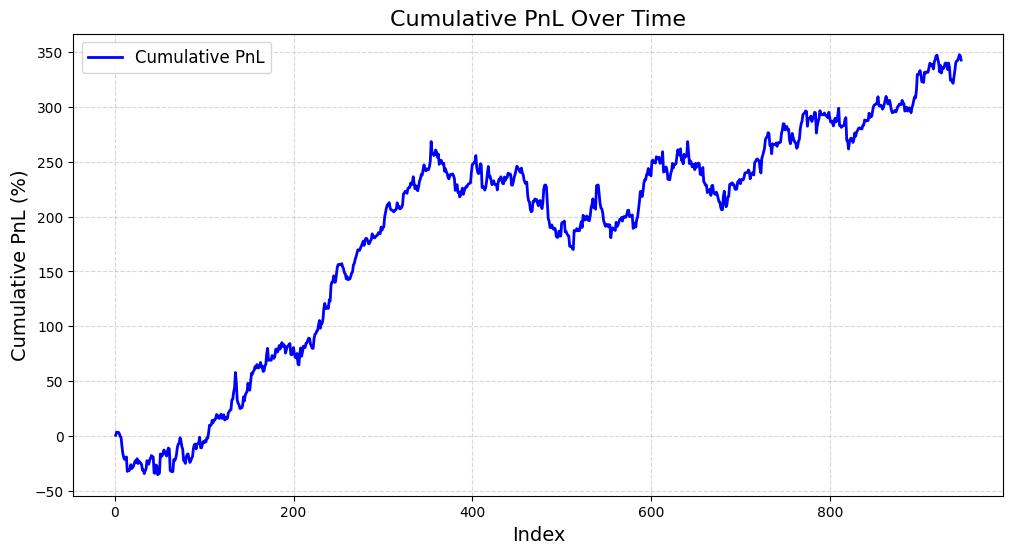

In [8]:
import matplotlib.pyplot as plt

# Plot the cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['cumulative_pnl'], label='Cumulative PnL', color='blue', linewidth=2)
plt.title('Cumulative PnL Over Time', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cumulative PnL (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()